### 累计成交量建模

上篇得出了单笔成交量大于某个值的概率表达式：

$$ P\left(\frac{q}{M} \geq r\right) = \left((1 + 20^{-r}) \cdot r + 1\right)^{alpha} $$

我们也关心一段时间的成交量的分布，直觉上它应该和每笔成交量和订单频率有关。下面把数据按照固定的间隔处理。和上文一样画出它的分布。

In [1]:
from datetime import date,datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trades = pd.read_csv('HOOKUSDT-aggTrades-2023-01-27.csv')
trades['date'] = pd.to_datetime(trades['transact_time'], unit='ms')
trades.index = trades['date']
buy_trades = trades[trades['is_buyer_maker']==False].copy()
buy_trades = buy_trades.groupby('transact_time').agg({
    'agg_trade_id': 'last',
    'price': 'last',
    'quantity': 'sum',
    'first_trade_id': 'first',
    'last_trade_id': 'last',
    'is_buyer_maker': 'last',
    'date': 'last',
    'transact_time':'last'
})
buy_trades['interval']=buy_trades['transact_time'] - buy_trades['transact_time'].shift()
buy_trades.index = buy_trades['date']

把逐笔成交每间隔1s合并成交量，去掉没发生交易的部分，还用上面的单笔成交的分布去拟合，可见结果比较好，把1s内的成交都看成单笔，这个问题变成了一个已经解决的问题。但当周期拉大(相对于成交频率），便发现误差增大，而研究发现这个误差正是有前面的帕累托分布修正项引起的。这说明当周期拉长，包含单个的成交越多，多个成交的合并越逼近帕累托分布，这种情形要去掉修正项。

In [3]:
df_resampled = buy_trades['quantity'].resample('1S').sum()
df_resampled = df_resampled.to_frame(name='quantity')
df_resampled = df_resampled[df_resampled['quantity']>0]

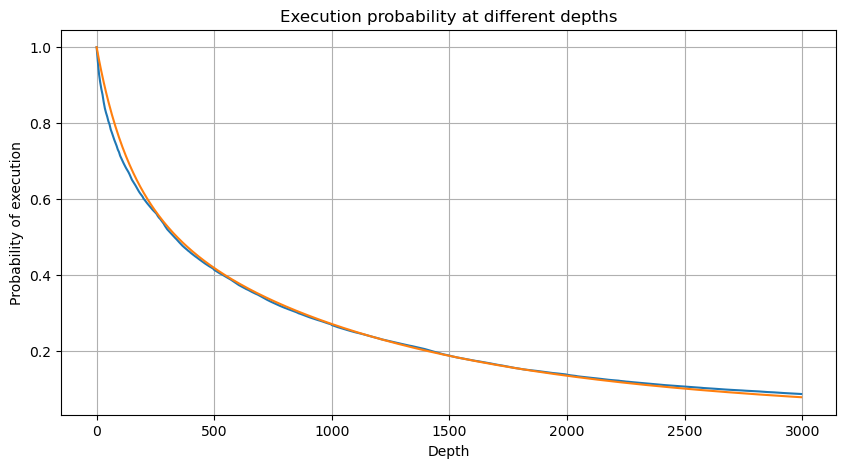

In [4]:
#1s内的累计分布
depths = np.array(range(0, 3000, 5))
probabilities = np.array([np.mean(df_resampled['quantity'] > depth) for depth in depths])
mean = df_resampled['quantity'].mean()
alpha = np.log(np.mean(df_resampled['quantity'] > mean))/np.log(2.05)
probabilities_s = np.array([((1+20**(-depth/mean))*depth/mean+1)**(alpha) for depth in depths])

plt.figure(figsize=(10, 5))
plt.plot(depths, probabilities)
plt.plot(depths, probabilities_s)
plt.xlabel('Depth')
plt.ylabel('Probability of execution')
plt.title('Execution probability at different depths')
plt.grid(True)

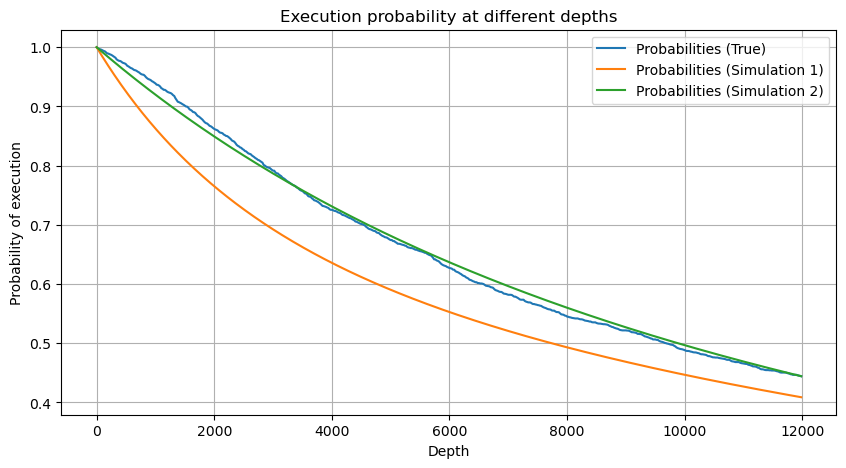

In [5]:
df_resampled = buy_trades['quantity'].resample('30S').sum()
df_resampled = df_resampled.to_frame(name='quantity')
df_resampled = df_resampled[df_resampled['quantity']>0]
depths = np.array(range(0, 12000, 20))
probabilities = np.array([np.mean(df_resampled['quantity'] > depth) for depth in depths])
mean = df_resampled['quantity'].mean()
alpha = np.log(np.mean(df_resampled['quantity'] > mean))/np.log(2.05)
probabilities_s = np.array([((1+20**(-depth/mean))*depth/mean+1)**(alpha) for depth in depths])
alpha = np.log(np.mean(df_resampled['quantity'] > mean))/np.log(2)
probabilities_s_2 = np.array([(depth/mean+1)**alpha for depth in depths]) # 无修正

plt.figure(figsize=(10, 5))
plt.plot(depths, probabilities,label='Probabilities (True)')
plt.plot(depths, probabilities_s, label='Probabilities (Simulation 1)')
plt.plot(depths, probabilities_s_2, label='Probabilities (Simulation 2)')
plt.xlabel('Depth')
plt.ylabel('Probability of execution')
plt.title('Execution probability at different depths')
plt.legend() 
plt.grid(True)

现在对于不同的时间累计的成交量的分布总结一个通用的公式，用单笔成交的分布去拟合，而不用每次分开统计。这里省去过程，直接给出公式：

$$ \text{adjust} = \frac{\text{avg_interval}}{\text{avg_interval_T}} $$

$$ P\left(\sum_{t}^{t+\Delta T} q \geq r*M\right) = \left( (1 + 20^{-r \cdot \text{adjust}}) \cdot r \cdot \text{adjust} + 1 \right)^{alpha} $$


其中avg_interval表示单笔成交的平均间隔，avg_interval_T表示需要估计的间隔的平均间隔，说的有点绕。假如我们要估计1s的成交, 需要统计1s内包含成交的事件平均间隔。如果订单到达的概率符合泊松分布，这里应该可以直接估计出来，但实际偏差很大，这里先不阐释。

注意这里的某间隔时间内成交量大于特定值的概率和实际在深度中该位置的成交概率应该差别较大，因为等待的时间越长，订单簿变化的可能性越大，并且成交也导致了深度的变化，因此相同深度位置的成交概率随着数据的更新是实时变化的。


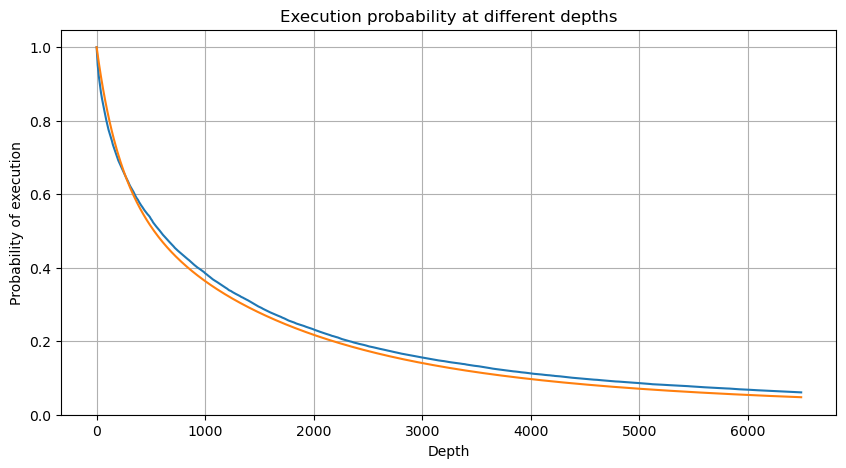

In [6]:
df_resampled = buy_trades['quantity'].resample('2S').sum()
df_resampled = df_resampled.to_frame(name='quantity')
df_resampled = df_resampled[df_resampled['quantity']>0]
depths = np.array(range(0, 6500, 10))
probabilities = np.array([np.mean(df_resampled['quantity'] > depth) for depth in depths])
mean = buy_trades['quantity'].mean()
adjust = buy_trades['interval'].mean() / 2620
alpha = np.log(np.mean(buy_trades['quantity'] > mean))/0.7178397931503168
probabilities_s = np.array([((1+20**(-depth*adjust/mean))*depth*adjust/mean+1)**(alpha) for depth in depths])

plt.figure(figsize=(10, 5))
plt.plot(depths, probabilities)
plt.plot(depths, probabilities_s)
plt.xlabel('Depth')
plt.ylabel('Probability of execution')
plt.title('Execution probability at different depths')
plt.grid(True)

### 单笔成交价格冲击

成交数据是个宝，可供挖掘的数据还有不少。我们应该非常关注订单对价格造成的冲击，这影响策略的挂单位置。同样根据transact_time聚合数据，计算最后一个价格和第一个价格的差，如果只有一个订单，差价为0。奇怪的是还有少量的数据结果为负的，应该是数据排列顺序的问题，这里就不深究了。

结果可见没有造成冲击的比例高达77%，1个tick的比例为16.5%，2个tick为3.7%，3个tick为1.2%，4个tick以上就小于1%了。这里基本符合指数函数的特点，但拟合的并不精确。

统计了造成相应差价的成交量，去掉冲击太大的失真，基本符合线性关系，大约每1000的量造成1个tick的价格波动。也可以理解为每个盘口附近价格的挂单量平均约为1000 。

In [7]:
diff_df = trades[trades['is_buyer_maker']==False].groupby('transact_time')['price'].agg(lambda x: abs(round(x.iloc[-1] - x.iloc[0],3)) if len(x) > 1 else 0)
buy_trades['diff'] = buy_trades['transact_time'].map(diff_df)

In [8]:
diff_counts = buy_trades['diff'].value_counts()
diff_counts[diff_counts>10]/diff_counts.sum()

0.000    0.769965
0.001    0.165527
0.002    0.037826
0.003    0.012546
0.004    0.005986
0.005    0.003173
0.006    0.001964
0.007    0.001036
0.008    0.000795
0.009    0.000474
0.010    0.000227
0.011    0.000187
0.012    0.000087
0.013    0.000080
Name: diff, dtype: float64

In [9]:
diff_group = buy_trades.groupby('diff').agg({
    'quantity': 'mean',
    'diff': 'last',
})

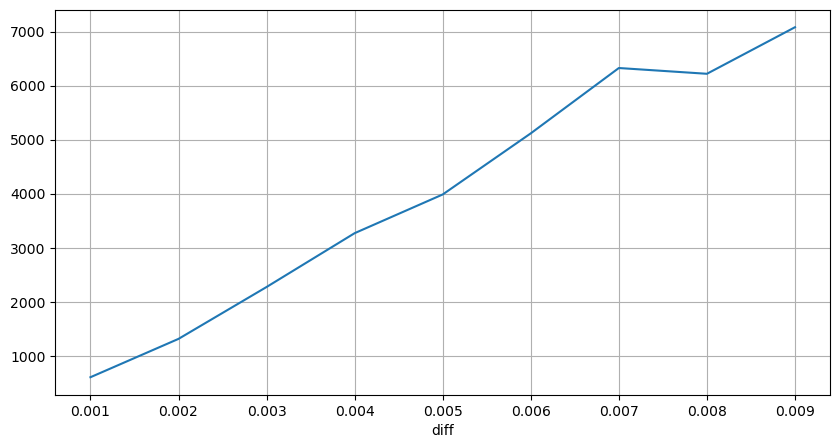

In [10]:
diff_group['quantity'][diff_group['diff']>0][diff_group['diff']<0.01].plot(figsize=(10,5),grid=True);

### 固定间隔的价格冲击

统计2s内的价格冲击，这里不同的是会有负值，当然由于这里只统计了买单，对称位置会大一个tick。继续观察成交量和冲击的关系，只统计大于0的结果，结论和单个订单的差不多，也是近似的线性关系，每个tick大约需要2000的量。

In [11]:
df_resampled = buy_trades.resample('2S').agg({ 
    'price': ['first', 'last', 'count'],
    'quantity': 'sum'
})
df_resampled['price_diff'] = round(df_resampled[('price', 'last')] - df_resampled[('price', 'first')],3)
df_resampled['price_diff'] = df_resampled['price_diff'].fillna(0)
result_df_raw = pd.DataFrame({
    'price_diff': df_resampled['price_diff'],
    'quantity_sum': df_resampled[('quantity', 'sum')],
    'data_count': df_resampled[('price', 'count')]
})
result_df = result_df_raw[result_df_raw['price_diff'] != 0]

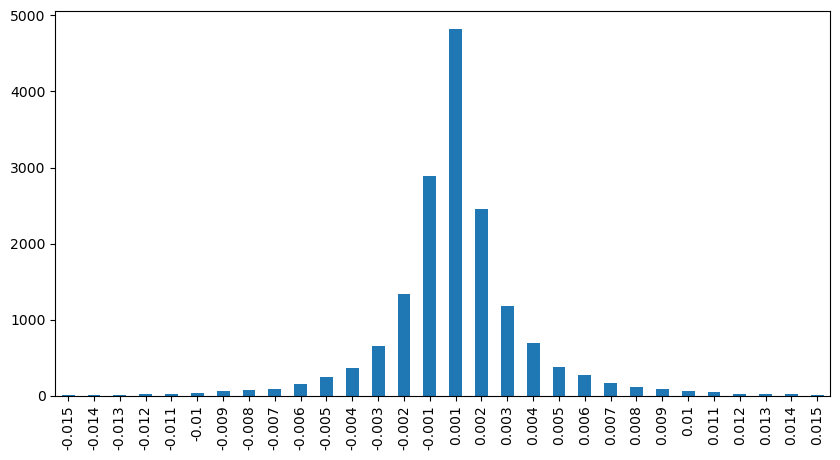

In [12]:
result_df['price_diff'][abs(result_df['price_diff'])<0.016].value_counts().sort_index().plot.bar(figsize=(10,5));

In [23]:
result_df['price_diff'].value_counts()[result_df['price_diff'].value_counts()>30]

 0.001    7176
-0.001    3665
 0.002    3069
-0.002    1536
 0.003    1260
 0.004     692
-0.003     608
 0.005     391
-0.004     322
 0.006     259
-0.005     192
 0.007     146
-0.006     112
 0.008      82
 0.009      75
-0.007      75
-0.008      65
 0.010      51
 0.011      41
-0.010      31
Name: price_diff, dtype: int64

In [14]:
diff_group = result_df.groupby('price_diff').agg({ 'quantity_sum': 'mean'})

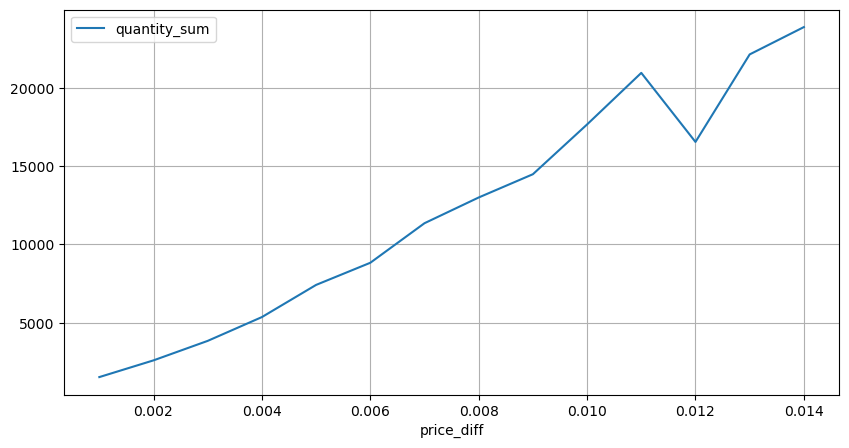

In [15]:
diff_group[(diff_group.index>0) & (diff_group.index<0.015)].plot(figsize=(10,5),grid=True);

### 成交量的价格冲击

前面求出了一个tick变化所需的成交量，但并不精确，因为是建立在假设冲击已经发生的情况下。现在反过来在看看成交量带来的价格冲击。

这里数据按1s取样，每100量为1个步长，统计了在这个数量范围内，价格的变动。得出了一些比较有价值的结论：

1. 当买单成交量低于500时，期望的价格变化是下跌，这是符合预期的，毕竟同时也有卖单在影响价格。
2. 在成交量较低时，符合线性关系，即成交量越大，带来的价格上涨越大。
3. 买单成交量越大，价格变化幅度越大，这时往往代表着价格的突破，突破后价格可能回归，再加上固定间隔的取样，造成了数据的不稳定。
4. 应该关注与散点图的上沿部分，即成交量对应价格上涨的部分。
4. 仅对于这个交易对，给出一个粗糙版的成交量带来价格变化的关系：

$$   C(Q) = \frac{Q}{3 \times 10^6} - 0.000352 $$

其中，"C" 表示价格的变化，"Q" 代表买单成交量。

In [16]:
df_resampled = buy_trades.resample('1S').agg({ 
    'price': ['first', 'last', 'count'],
    'quantity': 'sum'
})
df_resampled['price_diff'] = round(df_resampled[('price', 'last')] - df_resampled[('price', 'first')],3)
df_resampled['price_diff'] = df_resampled['price_diff'].fillna(0)
result_df_raw = pd.DataFrame({
    'price_diff': df_resampled['price_diff'],
    'quantity_sum': df_resampled[('quantity', 'sum')],
    'data_count': df_resampled[('price', 'count')]
})
result_df = result_df_raw[result_df_raw['price_diff'] != 0]

In [24]:
df = result_df.copy()
bins = np.arange(0, 30000, 100)  # 
labels = [f'{i}-{i+100-1}' for i in bins[:-1]]  
df.loc[:, 'quantity_group'] = pd.cut(df['quantity_sum'], bins=bins, labels=labels)
grouped = df.groupby('quantity_group')['price_diff'].mean()

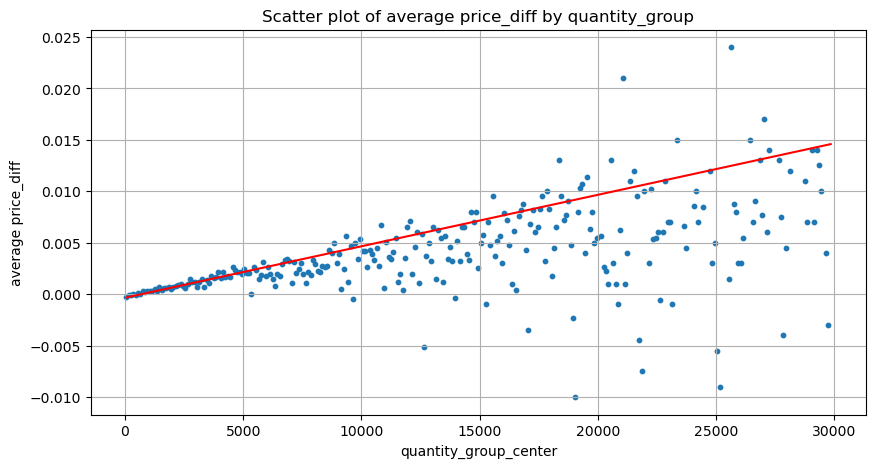

In [25]:
grouped_df = pd.DataFrame(grouped).reset_index()
grouped_df['quantity_group_center'] = grouped_df['quantity_group'].apply(lambda x: (float(x.split('-')[0]) + float(x.split('-')[1])) / 2)

plt.figure(figsize=(10,5))
plt.scatter(grouped_df['quantity_group_center'], grouped_df['price_diff'],s=10)
plt.plot(grouped_df['quantity_group_center'], np.array(grouped_df['quantity_group_center'].values)/2e6-0.000352,color='red')
plt.xlabel('quantity_group_center')
plt.ylabel('average price_diff')
plt.title('Scatter plot of average price_diff by quantity_group')
plt.grid(True)

In [19]:
grouped_df.head(10)

quantity_group  price_diff quantity_group_center
0          0-199   -0.000302                  99.5
1        100-299   -0.000124                 199.5
2        200-399   -0.000068                 299.5
3        300-499   -0.000017                 399.5
4        400-599   -0.000048                 499.5
5        500-699    0.000098                 599.5
6        600-799    0.000006                 699.5
7        700-899    0.000261                 799.5
8        800-999    0.000186                 899.5
9       900-1099    0.000299                 999.5

### 初步最优挂单位置

有了对成交量的建模和成交量对应价格冲击的粗糙模型，似乎可以计算最优的挂单位置了。不妨做一些假设，先给出一个不负责任的最优价格位置。

1. 假设冲击后价格回归原始值(这个当然不太可能，需要对冲击后价格的变化进行再分析)
2. 假设这段时间成交量和订单频率的分布符合预设(这也是不准确的，这里用一天的值进行估计，而交易有明显的聚集现象）。
3. 假设模拟时间内只发生一个卖单，然后平仓。
4. 假设订单成交后，有其他的买单继续推高价格，特别是在量很低时明显，这里忽略了这种效应，简单认为还会回归。

先写出一个简单的期望收益，即1s内累计买单大于Q的概率，乘以预期收益率（即冲击的价格)：


$$ E(\text{profit|Q}) = C(Q) \cdot P(Q) $$

根据图像，期望收益大约在2500左右最大, 约为平均成交量的2.5倍。就是说卖单应该挂在2500的位置上。需要再次强调的是，横轴代表1s内的交易量，不能简单等同与深度位置。并且这是目前还缺乏很重要深度数据的时候，只根据trades的推测。

### 总结

发现不同时间间隔成交量分布是一个关于单笔成交量分布的简单缩放。还根据价格冲击和成交概率做了一个简单的期望收益模型，这个模型的结果符合我们的预期，如果卖单成交量小，预示着价格的下跌，需要一定的量才有利润空间，而交易量越大的概率越低，中间存在一个最优的大小，也是策略寻找的挂单位置。当然，这个模型还是太简单，下篇文章，我将继续深入谈谈。

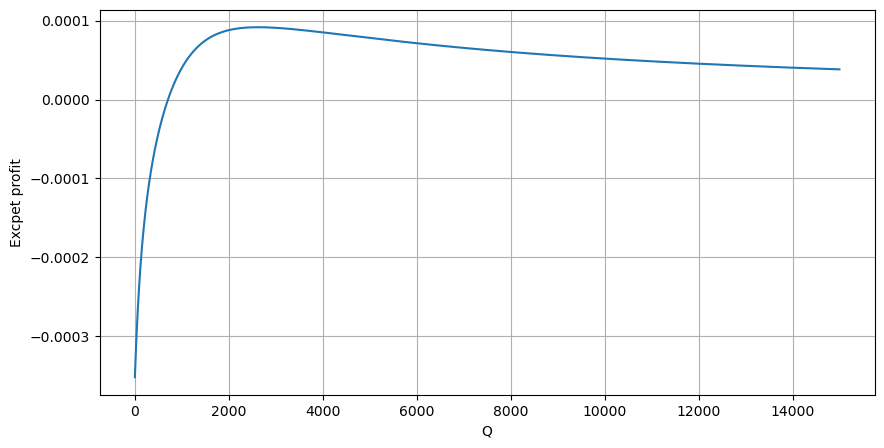

In [20]:
#1s内的累计分布
df_resampled = buy_trades['quantity'].resample('1S').sum()
df_resampled = df_resampled.to_frame(name='quantity')
df_resampled = df_resampled[df_resampled['quantity']>0]

depths = np.array(range(0, 15000, 10))
mean = df_resampled['quantity'].mean()
alpha = np.log(np.mean(df_resampled['quantity'] > mean))/np.log(2.05)
probabilities_s = np.array([((1+20**(-depth/mean))*depth/mean+1)**(alpha) for depth in depths])
profit_s = np.array([depth/2e6-0.000352 for depth in depths])
plt.figure(figsize=(10, 5))
plt.plot(depths, probabilities_s*profit_s)
plt.xlabel('Q')
plt.ylabel('Excpet profit')
plt.grid(True)